## Applying pyspark

In [1]:
# install pyspark
#!pip install pyspark

In [2]:
import sys

print("Python Version:", sys.version)
print("Virtual Environment Path:", sys.prefix)

Python Version: 3.11.6 (main, Oct  8 2023, 05:06:43) [GCC 13.2.0]
Virtual Environment Path: /usr


In [3]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [4]:
import warnings
warnings.filterwarnings("ignore")

 <h3>Comands to start using hadoop:</h3>


<ul style="list-style-type: none;">
  <li>start-dfs.sh</li>
  <li>start-yarn.sh</li>
</ul>

 <h3>command to stop the process:</h3>

<ul style="list-style-type: none;">
  <li>stop-dfs.sh </li>
  <li>stop-yarn.sh</li>
</ul>

In [5]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder \
    .appName("Read CSV from HDFS") \
    .getOrCreate()

# Relative Path in HDFS
# csv_file_path = "/first_CA_second_sem/TSM10.20240320205332.csv"

csv_file_path = "hdfs://localhost:9000/first_CA_second_sem/TSM10.20240320205332.csv"

# Read the CSV file into a DataFrame
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)


24/03/26 08:22:21 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [6]:
default_fs = spark._jsc.hadoopConfiguration().get("fs.defaultFS")

In [7]:
print("default_fs path is: ", default_fs)

default_fs path is:  hdfs://localhost:9000


In [8]:
# Show the DataFrame
df.show(5)

+---------+----------------+---------+------------+------------+--------------------+------------+---------+-------------+------+
|STATISTIC| Statistic Label|TLIST(M1)|       Month|C02487V03011|     Commodity group|C03409V04104|  Country|         UNIT| VALUE|
+---------+----------------+---------+------------+------------+--------------------+------------+---------+-------------+------+
| TSM10C01|Value of Imports|   201501|2015 January|         101|Total merchandise...|          AT|  Austria|Euro Thousand| 15321|
| TSM10C01|Value of Imports|   201501|2015 January|         101|Total merchandise...|          AU|Australia|Euro Thousand|  5064|
| TSM10C01|Value of Imports|   201501|2015 January|         101|Total merchandise...|          BE|  Belgium|Euro Thousand|109964|
| TSM10C01|Value of Imports|   201501|2015 January|         101|Total merchandise...|          BG| Bulgaria|Euro Thousand| 33988|
| TSM10C01|Value of Imports|   201501|2015 January|         101|Total merchandise...|     

In [9]:
type(df)

pyspark.sql.dataframe.DataFrame

In [10]:
df.printSchema()

root
 |-- STATISTIC: string (nullable = true)
 |-- Statistic Label: string (nullable = true)
 |-- TLIST(M1): integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- C02487V03011: integer (nullable = true)
 |-- Commodity group: string (nullable = true)
 |-- C03409V04104: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- UNIT: string (nullable = true)
 |-- VALUE: integer (nullable = true)



In [11]:
df.columns

['STATISTIC',
 'Statistic Label',
 'TLIST(M1)',
 'Month',
 'C02487V03011',
 'Commodity group',
 'C03409V04104',
 'Country',
 'UNIT',
 'VALUE']

In [12]:
# Get statistical summary of the DataFrame
df.describe().show(5)


24/03/26 08:22:32 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+---------+----------------+------------------+------------+-----------------+--------------------+------------+---------+-------------+-----------------+
|summary|STATISTIC| Statistic Label|         TLIST(M1)|       Month|     C02487V03011|     Commodity group|C03409V04104|  Country|         UNIT|            VALUE|
+-------+---------+----------------+------------------+------------+-----------------+--------------------+------------+---------+-------------+-----------------+
|  count|   705012|          705012|            705012|      705012|           705012|              705012|      705012|   705012|       705012|           496279|
|   mean|     null|            null| 201911.0366972477|        null|5051.712121212121|                null|        null|     null|         null|9231.518990326007|
| stddev|     null|            null|261.32310506497976|        null|2875.646182107541|                null|        null|     null|         null|91717.59880938345|
|    min| TSM10C01|Val

In [13]:
# selecting columns with spark method
selected_df = df.select('TLIST(M1)', "Commodity group", "VALUE")


In [14]:
selected_df.show(5)


+---------+--------------------+------+
|TLIST(M1)|     Commodity group| VALUE|
+---------+--------------------+------+
|   201501|Total merchandise...| 15321|
|   201501|Total merchandise...|  5064|
|   201501|Total merchandise...|109964|
|   201501|Total merchandise...| 33988|
|   201501|Total merchandise...| 12169|
+---------+--------------------+------+
only showing top 5 rows



In [15]:
# Create a temporary view using the DataFrame
df.createOrReplaceTempView("commodity_data")

In [16]:
# Getting a list of table names
table_names = spark.catalog.listTables()

print("table names: ", table_names)

table names:  [Table(name='commodity_data', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True)]


In [17]:
# Write and execute the SQL query
sql_query = """
SELECT `TLIST(M1)`, `Commodity group`, VALUE
FROM commodity_data
WHERE `Commodity group` = 'Miscellaneous manufactured articles, n.e.s. (89)'
AND Country = 'Austria'
"""

result_df = spark.sql(sql_query)

# Show the last 5 rows of the result DataFrame
result_df.show(5)


+---------+--------------------+-----+
|TLIST(M1)|     Commodity group|VALUE|
+---------+--------------------+-----+
|   201501|Miscellaneous man...| 2020|
|   201502|Miscellaneous man...| 2522|
|   201503|Miscellaneous man...| 2978|
|   201504|Miscellaneous man...| 2842|
|   201505|Miscellaneous man...| 1978|
+---------+--------------------+-----+
only showing top 5 rows



In [18]:
total_rows = result_df.count()
print("Total rows in VALUE column:", total_rows)

Total rows in VALUE column: 218


In [19]:
# Check for null values in the DataFrame
null_count = result_df.filter(result_df.VALUE.isNull()).count()

if null_count > 0:
    print("There are empty values in the 'VALUE' column.")
else:
    print("There are no empty values in the 'VALUE' column.")


There are no empty values in the 'VALUE' column.


In [20]:
#!pip install tensorflow
# As tensorflow it got some troubles to installing because of the "error: externally-managed-environment"
#another solution is the use of pytorch library

In [21]:
# check installed libraries
#!pip list

In [22]:
#!pip install torch

In [23]:
# Drop empty values in the "VALUE" column
dropped_df = result_df.dropna(subset=['VALUE'])

# Show the last 5 rows of the result DataFrame
dropped_df.show(5)


+---------+--------------------+-----+
|TLIST(M1)|     Commodity group|VALUE|
+---------+--------------------+-----+
|   201501|Miscellaneous man...| 2020|
|   201502|Miscellaneous man...| 2522|
|   201503|Miscellaneous man...| 2978|
|   201504|Miscellaneous man...| 2842|
|   201505|Miscellaneous man...| 1978|
+---------+--------------------+-----+
only showing top 5 rows



In [24]:
result_df.count()

218

In [25]:
result_df.count()

218

In [26]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler


# Vector Assembler to convert features to a single vector column
vecAssembler = VectorAssembler(inputCols=["VALUE"], outputCol="features")
df_new = vecAssembler.transform(result_df).select("features")

In [27]:
print(df_new)

DataFrame[features: vector]


In [28]:
# Convert Spark DataFrame to RDD and then to NumPy array
data_array = np.array(df_new.rdd.map(lambda x: x.features[0]).collect())

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_array.reshape(-1, 1))

In [29]:
# Define a function to create sequences for input/output
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [30]:
# Define sequence length and split data into training and testing sets
sequence_length = 10
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size], scaled_data[train_size:len(scaled_data)]

In [31]:
# Create sequences for training and testing sets
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [32]:
# Convert data to PyTorch tensors
X_train = torch.Tensor(X_train).unsqueeze(2)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test).unsqueeze(2)
y_test = torch.Tensor(y_test)

In [33]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [34]:
# Instantiate the model, define loss function and optimizer
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [35]:
# Train the model
epochs = 150
for i in range(epochs):
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 0:
        print(f'Epoch: {i:3} loss: {single_loss.item():10.8f}')


Epoch:   0 loss: 0.00441951
Epoch:  25 loss: 0.00135869
Epoch:  50 loss: 0.00116209
Epoch:  75 loss: 0.00111984
Epoch: 100 loss: 0.00044867
Epoch: 125 loss: 0.00379041


In [36]:
# Test the model
test_losses = []
with torch.no_grad():
    for seq, labels in zip(X_test, y_test):
        y_pred = model(seq)
        test_loss = loss_function(y_pred, labels)
        test_losses.append(test_loss.item())

print(f'Average Test Loss: {np.mean(test_losses):10.8f}')


Average Test Loss: 0.04081734


In [37]:
# Make predictions
predictions = []
with torch.no_grad():
    for seq in X_test:
        predictions.append(model(seq).item())


In [38]:
# Inverse transform the predictions
predicted_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

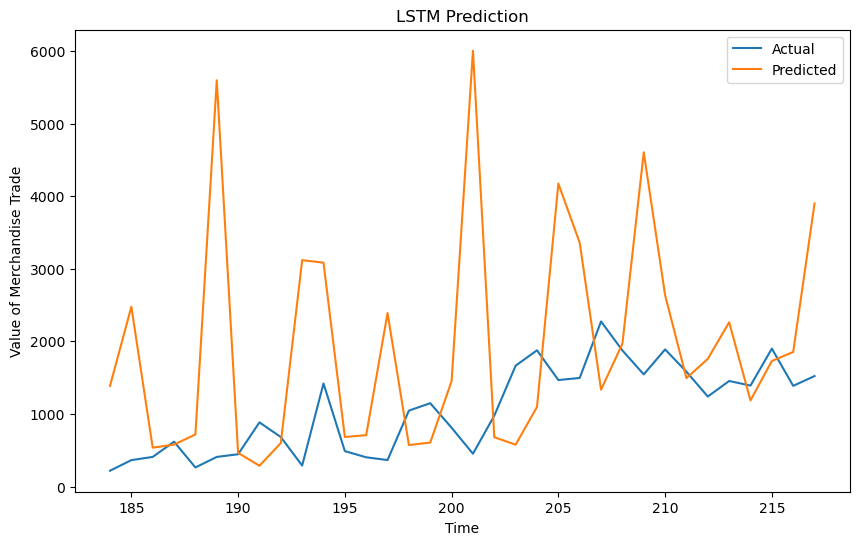

In [39]:
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(len(data_array) - len(predicted_values), len(data_array)), data_array[-len(predicted_values):], label='Actual')
plt.plot(range(len(data_array) - len(predicted_values), len(data_array)), predicted_values, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value of Merchandise Trade')
plt.title('LSTM Prediction')
plt.legend()
plt.show()


In [40]:
# Stop the SparkSession
#spark.stop()